# Customer Churn Model Development

<b>Use xgboost to build a binary classifier to predict customer churn</b>

This notebook has been inspired by <a href="https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb">This github blog post</a>

The idea behind this notebook is to learn about model development using Sagemaker and deployment through lambda functions and endpoints.

Losing customers is costly for any business. Identifying unhappy customers early on gives you a chance to offer them incentives to stay. This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator. Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

## Setup

In this part we setup our sagemaker session and assign S3 buckets to hold training data.

In [1]:
import sagemaker
import boto3

In [2]:
role = sagemaker.get_execution_role()

sess = sagemaker.Session()

prefix = "agni/cust-chur-model"

bucket = sess.default_bucket()

In [3]:
bucket

'sagemaker-ap-south-1-573002217864'

In [4]:
import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import matplotlib.pyplot as plt  # For charts and visualizations
from IPython.display import Image  # For displaying images in the notebook
from IPython.display import display  # For displaying outputs in the notebook
from time import gmtime, strftime  # For labeling SageMaker models, endpoints, etc.
import sys  # For writing outputs to notebook
import math  # For ceiling function
import json  # For parsing hosting outputs
import os  # For manipulating filepath names
import zipfile  # unzips the dataset
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker.serializers import CSVSerializer
from sklearn import metrics

## Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book <b><i>Discovering Knowledge in Data by Daniel T. Larose</i></b>. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. Let's download and read that dataset in now:

In [5]:
!aws s3 cp s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt ./

download: s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt to ./churn.txt


In [6]:
df = pd.read_csv("churn.txt")
pd.set_option('display.max_columns', 500)
df.sample(10)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
911,DE,176,686,654-9544,no,no,0,3.252984,2,4.178406,6.249517,1,3.802665,4.672075,350,4.297069,6.236040,5,5.094090,6,False.
3331,OR,161,798,917-8492,no,no,0,4.668746,4,5.036016,5.312833,4,4.501530,4.984486,200,4.699377,4.924377,5,4.456267,5,False.
3453,KY,166,758,120-9083,yes,no,0,8.591983,3,4.839676,5.092915,2,6.963763,1.251744,150,8.603571,5.516964,7,0.655715,8,True.
1549,WA,45,876,606-9801,no,no,0,0.675234,2,4.085756,4.908682,3,2.617261,5.093991,200,2.150701,6.006064,3,8.236272,4,False.
4664,KS,139,758,165-8288,no,no,0,5.033987,3,5.577296,5.113515,4,5.175188,5.774128,150,4.348351,6.458719,2,7.199203,5,True.
3984,OK,126,797,797-6457,no,yes,500,5.319213,4,2.190806,2.672553,6,0.456497,2.828546,300,0.167476,4.695892,5,5.901662,3,False.
197,MD,71,776,250-1983,no,yes,600,2.118628,1,4.254913,3.248302,1,4.057379,2.441746,150,4.168540,5.456875,4,6.317301,5,False.
2546,MN,108,777,355-9197,yes,yes,300,4.566259,3,4.951987,3.070478,3,5.133985,5.020449,200,5.810441,4.692715,2,3.165299,7,True.
998,CO,76,677,359-2080,yes,no,0,10.649208,3,7.529589,6.457939,4,6.336908,5.594848,100,5.539594,3.921123,8,5.304162,3,True.
3433,OK,188,797,860-2095,no,no,0,1.338861,4,3.539921,6.262378,4,1.255770,2.493981,150,2.647235,6.510729,3,7.155026,4,False.


By modern standards, it’s a relatively small dataset, with only 5,000 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:
<ul>
    <li>State: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ</li>
    <li>Account Length: the number of days that this account has been active</li>
    <li>Area Code: the three-digit area code of the corresponding customer’s phone number</li>
    <li>Phone: the remaining seven-digit phone number</li>
    <li>Int’l Plan: whether the customer has an international calling plan: yes/no</li>
    <li>VMail Plan: whether the customer has a voice mail feature: yes/no</li>
    <li>VMail Message: presumably the average number of voice mail messages per month</li>
    <li>Day Mins: the total number of calling minutes used during the day</li>
    <li>Day Calls: the total number of calls placed during the day</li>
    <li>Day Charge: the billed cost of daytime calls</li>
    <li>Eve Mins, Eve Calls, Eve Charge: the billed cost for calls placed during the evening</li>
    <li>Night Mins, Night Calls, Night Charge: the billed cost for calls placed during nighttime</li>
    <li>Intl Mins, Intl Calls, Intl Charge: the billed cost for international calls</li>
    <li>CustServ Calls: the number of calls placed to Customer Service</li>
    <li>Churn?: whether the customer left the service: true/false</li>
</ul>

## Exploration

----------------- State --------------------


col_0,% observations
State,
ME,0.0148
KS,0.0158
ND,0.0160
NM,0.0166
GA,0.0166
AK,0.0170
WI,0.0170
CT,0.0178
FL,0.0178


----------------- Int'l Plan --------------------


col_0,% observations
Int'l Plan,
yes,0.4986
no,0.5014


----------------- VMail Plan --------------------


col_0,% observations
VMail Plan,
no,0.4976
yes,0.5024


----------------- Churn? --------------------


col_0,% observations
Churn?,
True.,0.4996
False.,0.5004


,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,101.675800,773.791400,226.680000,5.518757,3.50460,5.018902,5.026199,3.140400,5.017557,4.000917,224.790000,5.023490,5.025876,5.475400,4.328242,5.525800
std,57.596762,63.470888,273.998527,3.433485,1.68812,2.195759,2.135487,2.525621,2.127857,1.631001,97.302875,1.748900,1.019302,1.877045,2.440311,2.041217
min,1.000000,657.000000,0.000000,0.000215,0.00000,0.004777,0.004659,0.000000,0.013573,0.008468,0.000000,0.054863,1.648514,0.000000,0.000769,0.000000
25%,52.000000,736.000000,0.000000,2.682384,2.00000,3.470151,3.588466,1.000000,3.529613,2.921998,150.000000,3.873157,4.349726,4.000000,2.468225,4.000000
50%,102.000000,778.000000,0.000000,5.336245,3.00000,4.988291,5.145656,3.000000,5.006860,3.962089,200.000000,5.169154,5.034905,5.000000,4.214058,6.000000
75%,151.000000,806.000000,400.000000,7.936151,5.00000,6.559750,6.552962,5.000000,6.491725,5.100128,300.000000,6.272015,5.716386,7.000000,5.960654,7.000000
max,200.000000,878.000000,1300.000000,16.897529,10.00000,12.731936,13.622097,14.000000,12.352871,10.183378,550.000000,10.407778,8.405644,12.000000,14.212261,13.000000


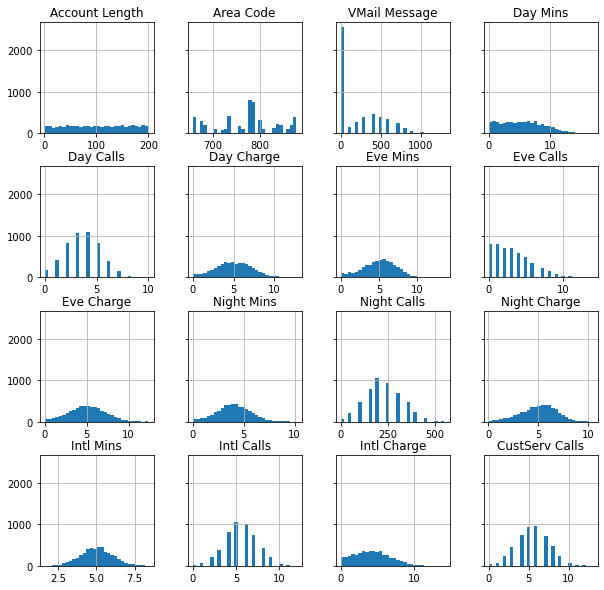

In [7]:
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=["object"]).columns:
    if len(df[column].unique()) < (0.2*len(df)):
        print("----------------- {} --------------------".format(column))
        display(pd.crosstab(index=df[column], columns="% observations", normalize="columns").sort_values(by='% observations'))

# Histograms for each numeric features
display(df.describe())
%matplotlib inline
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

Key Highlights:

<ul>
    <li>State: The distribution of customers is uniform across states</li>
    <li>Churn?: The target feature is balanced which is a good thing for model building</li>
    <li>Phone: Has been skiped from analysis as it has too many unique values to be of any use.</li>
    <li>Area Code: Should be a categorical feature</li>
    <li>Most numeric features are well balanced</li>
</ul>

In [8]:
df = df.drop(['Phone'], axis=1)
df['Area Code'] = df['Area Code'].astype(object)

--------------- State -------------------


Churn?,False.,True.
State,,
AK,0.015588,0.018415
AL,0.021583,0.018415
AR,0.022782,0.021217
AZ,0.015588,0.020416
CA,0.020384,0.021217
CO,0.018785,0.017614
CT,0.015588,0.020016
DC,0.022382,0.022418
DE,0.018385,0.018014


--------------- Area Code -------------------


Churn?,False.,True.
Area Code,,
657,0.037170,0.036829
658,0.022782,0.021217
659,0.015588,0.020416
676,0.020384,0.021217
677,0.018785,0.017614
678,0.015588,0.020016
686,0.040767,0.040432
707,0.019984,0.015612
716,0.017986,0.015212


--------------- Int'l Plan -------------------


Churn?,False.,True.
Int'l Plan,,
no,0.5,0.502802
yes,0.5,0.497198


--------------- VMail Plan -------------------


Churn?,False.,True.
VMail Plan,,
no,0.496403,0.498799
yes,0.503597,0.501201


--------------- Account Length -------------------


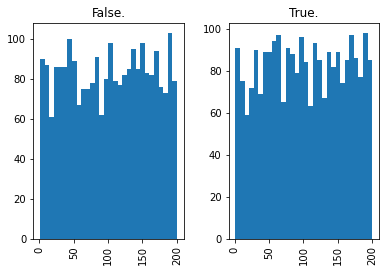

--------------- VMail Message -------------------


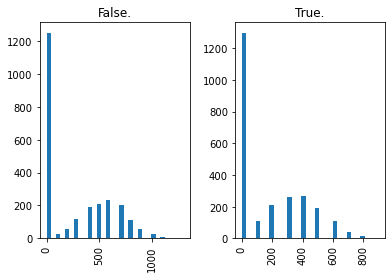

--------------- Day Mins -------------------


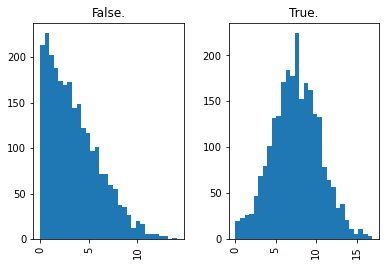

--------------- Day Calls -------------------


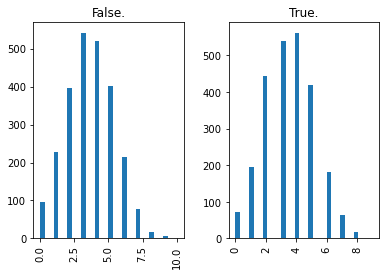

--------------- Day Charge -------------------


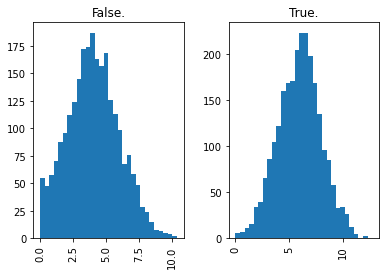

--------------- Eve Mins -------------------


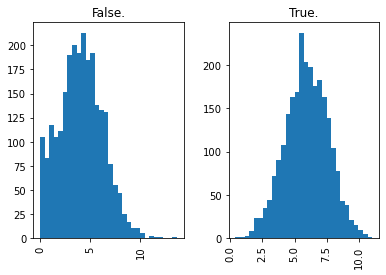

--------------- Eve Calls -------------------


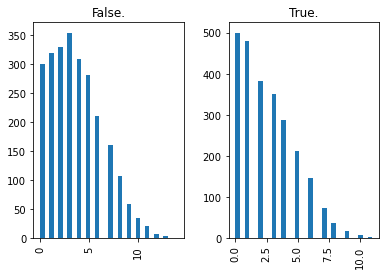

--------------- Eve Charge -------------------


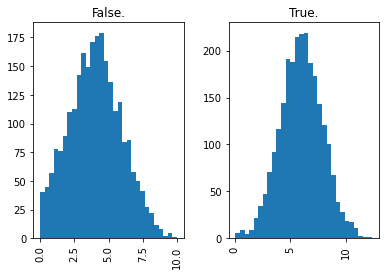

--------------- Night Mins -------------------


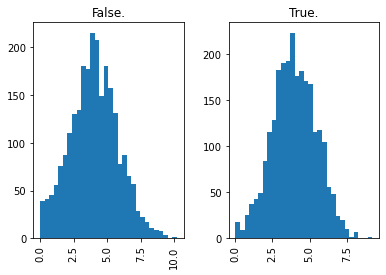

--------------- Night Calls -------------------


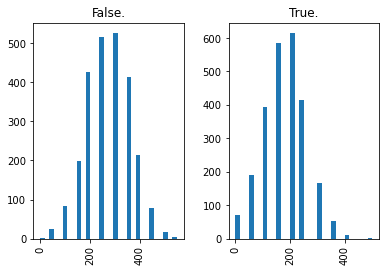

--------------- Night Charge -------------------


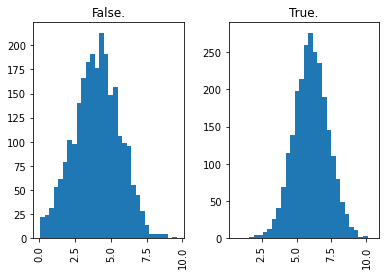

--------------- Intl Mins -------------------


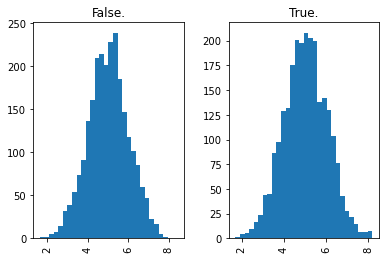

--------------- Intl Calls -------------------


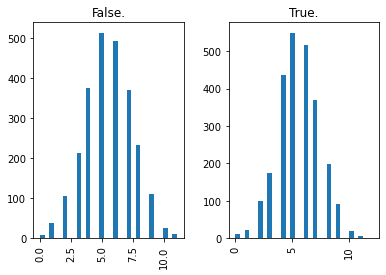

--------------- Intl Charge -------------------


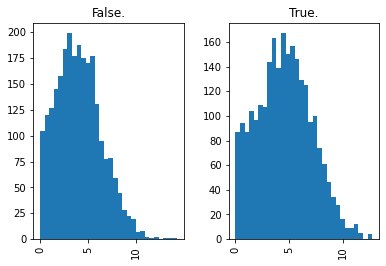

--------------- CustServ Calls -------------------


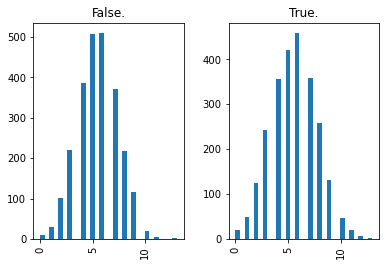

In [9]:
for column in df.select_dtypes(include=["object"]).columns:
    if column != "Churn?":
        print(f"--------------- {column} -------------------")
        display(pd.crosstab(index=df[column], columns=df["Churn?"], normalize="columns"))

for column in df.select_dtypes(exclude=["object"]).columns:
    print(f"--------------- {column} -------------------")
    hist = df[[column, "Churn?"]].hist(by="Churn?", bins=30)
    plt.show()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.009030,-0.015878,0.011659,-0.007468,0.000213,0.026515,-0.012795,0.016400,-0.002383,-0.034925,0.017277,-0.003735,0.028285,-0.036721
VMail Message,-0.009030,1.000000,-0.143272,0.002762,-0.182712,-0.104667,-0.101240,-0.029212,0.061370,0.135042,-0.155475,-0.015162,0.131964,0.010120,0.068657
Day Mins,-0.015878,-0.143272,1.000000,-0.087598,0.667941,0.482641,-0.184939,0.766489,0.188190,-0.445212,0.570508,0.001988,0.236131,0.239331,-0.195322
Day Calls,0.011659,0.002762,-0.087598,1.000000,-0.222556,0.033903,0.185881,-0.052051,-0.085222,-0.083050,0.046641,-0.022548,-0.045671,-0.120064,-0.065518
Day Charge,-0.007468,-0.182712,0.667941,-0.222556,1.000000,0.574697,0.236626,0.371580,0.150700,-0.130722,0.374861,0.010294,0.119584,0.251748,-0.260945
Eve Mins,0.000213,-0.104667,0.482641,0.033903,0.574697,1.000000,-0.067123,0.269980,-0.090515,0.067315,0.317481,-0.015678,0.070456,0.448910,-0.167347
Eve Calls,0.026515,-0.101240,-0.184939,0.185881,0.236626,-0.067123,1.000000,-0.467814,0.221439,0.218149,-0.324936,-0.001593,-0.112062,0.017036,-0.433467
Eve Charge,-0.012795,-0.029212,0.766489,-0.052051,0.371580,0.269980,-0.467814,1.000000,0.184230,-0.454649,0.546137,-0.003569,0.164104,0.243936,-0.011019
Night Mins,0.016400,0.061370,0.188190,-0.085222,0.150700,-0.090515,0.221439,0.184230,1.000000,-0.223023,-0.140482,-0.012781,0.038831,0.271179,-0.332802
Night Calls,-0.002383,0.135042,-0.445212,-0.083050,-0.130722,0.067315,0.218149,-0.454649,-0.223023,1.000000,-0.390333,-0.009821,0.181237,-0.155736,0.110211


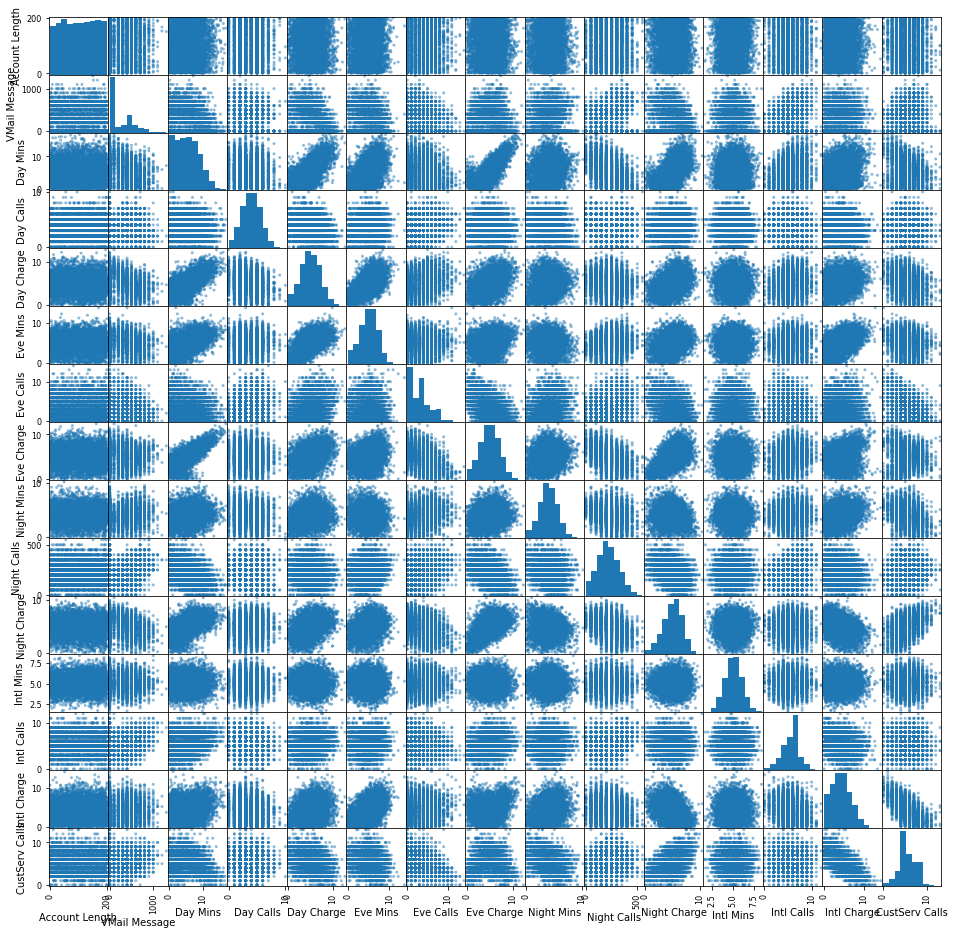

In [10]:
display(df.corr())
pd.plotting.scatter_matrix(df, figsize=(16, 16))
plt.show()

## Transformation

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [12]:
X, y = df.drop(['Churn?'], axis=1), df['Churn?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
one_hot = OneHotEncoder()
s_scaler = StandardScaler()

obj_cols = X_train.select_dtypes(include=["object"]).columns
num_cols = X_train.select_dtypes(exclude=["object"]).columns

one_hot = one_hot.fit(X_train[obj_cols])
s_scaler = s_scaler.fit(X_train[num_cols])

X_train = np.c_[one_hot.transform(X_train[obj_cols]).toarray(), s_scaler.transform(X_train[num_cols])]
X_test = np.c_[one_hot.transform(X_test[obj_cols]).toarray(), s_scaler.transform(X_test[num_cols])]

lb = LabelBinarizer().fit(y_train)
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

In [28]:
trans = {
    'One_Hot': one_hot,
    'scaler': s_scaler,
    'label': lb,
    'obj_cols': list(obj_cols),
    'num_cols': list(num_cols)
}

with open("transformation.sav", 'wb') as file:
    import pickle
    pickle.dump(trans, file)

In [31]:
obj_cols

Index(['State', 'Area Code', 'Int'l Plan', 'VMail Plan'], dtype='object')

In [15]:
pd.DataFrame(np.c_[y_train, X_train]).to_csv('train.csv', index=False)
pd.DataFrame(np.c_[y_test, X_test]).to_csv('test.csv', index=False)

In [30]:
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train/train.csv")
).upload_file("train.csv")

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "test/test.csv")
).upload_file("test.csv")

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "transformation/transformation.sav")
).upload_file("transformation.sav")

## Training

In [17]:
# Locate XGBOOST container
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, "1")
display(container)

'991648021394.dkr.ecr.ap-south-1.amazonaws.com/xgboost:1'

In [18]:
s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_test = TrainingInput(
    s3_data="s3://{}/{}/test/".format(bucket, prefix), content_type="csv"
)

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters. A few key hyperparameters are:
<ul>
<li>max_depth controls how deep each tree within the algorithm can be built. Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting. There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.</li>
<li>subsample controls sampling of the training data. This technique can help reduce overfitting, but setting it too low can also starve the model of data.</li>
<li>Lnum_round controls the number of boosting rounds. This is essentially the subsequent models that are trained using the residuals of previous iterations. Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.</li>
<li>eta controls how aggressive each round of boosting is. Larger values lead to more conservative boosting.
gamma controls how aggressively trees are grown. Larger values lead to more conservative models.</li>

In [19]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
    use_spot_instances=True,
    max_run=300,
    max_wait=600
)

xgb.set_hyperparameters(
    max_depth=7,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective="binary:logistic",
    num_round=100,
)

In [20]:
xgb.fit({"train": s3_input_train, "validation": s3_input_test})

2021-06-02 15:08:22 Starting - Starting the training job...
2021-06-02 15:08:45 Starting - Launching requested ML instancesProfilerReport-1622646502: InProgress
......
2021-06-02 15:09:45 Starting - Preparing the instances for training......
2021-06-02 15:10:51 Downloading - Downloading input data
2021-06-02 15:10:51 Training - Downloading the training image...
2021-06-02 15:11:19 Uploading - Uploading generated training modelArguments: train
[2021-06-02:15:11:14:INFO] Running standalone xgboost training.
[2021-06-02:15:11:14:INFO] File size need to be processed in the node: 3.1mb. Available memory size in the node: 8370.75mb
[2021-06-02:15:11:14:INFO] Determined delimiter of CSV input is ','
[15:11:14] S3DistributionType set as FullyReplicated
[15:11:14] 4001x103 matrix with 412103 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-06-02:15:11:14:INFO] Determined delimiter of CSV input is ','
[15:11:14] S3DistributionType set as FullyReplicated
[1


2021-06-02 15:11:46 Completed - Training job completed
Training seconds: 50
Billable seconds: 13
Managed Spot Training savings: 74.0%


## Hosting

In [21]:
xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

-------------!

## Evaluate

In [22]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = ",".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return np.fromstring(predictions[1:], sep=",")

test_data = df.sample(1000)
test_data_X = np.c_[one_hot.transform(test_data[obj_cols]).toarray(), s_scaler.transform(test_data[num_cols])]
test_data_y = lb.transform(test_data['Churn?'])
predictions = predict(test_data_X)

In [23]:
pd.crosstab(
    index=lb.inverse_transform(test_data_y),
    columns=lb.inverse_transform(predictions > 0.5),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions,False.,True.
actual,,
False.,483,18
True.,11,488


So we got <b>Accuracy Score of 97.2%</b> and <b>Recall Score of 96.2%</b> with only <b>19 False Negatives</b>

## Cost Analysis

Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives. Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction.

Assigning costs
What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, assign the true negatives the cost of 0 dollars. Our model essentially correctly identified a happy customer in this case, and we don’t need to do anything.

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the purposes of this example, let's assume 500 dollars. This is the cost of false negatives.

Finally, for customers that our model identifies as churning, let's assume a retention incentive in the amount of 100 dollars. If my provider offered me such a concession, I’d certainly think twice before leaving. This is the cost of both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the 100 dollars concession. We probably could have spent that 100 dollars more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad.

Finding the optimal cutoff
It’s clear that false negatives are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we should be minimizing a cost function that looks like this:


$ 500 * FN(C) + 0 * TN(C) + 100 * FP(C) + 100 * TP(C) $

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP. We need to find the cutoff, C, where the result of the expression is smallest.

A straightforward way to do this, is to simply run a simulation over a large number of possible cutoffs. We test 100 possible values in the for loop below

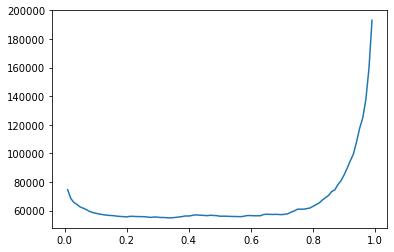

In [24]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(
        np.sum(
            np.sum(
                np.array([[0, 100], [500, 100]])
                * pd.crosstab(index=test_data_y[:,0], columns=np.where(predictions > c, 1, 0))
            )
        )
    )

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.show()

In [25]:
print(
    "Cost is minimized near a cutoff of:",
    cutoffs[np.argmin(costs)],
    "for a cost of:",
    np.min(costs),
)

Cost is minimized near a cutoff of: 0.34 for a cost of: 54900


In [26]:
pd.crosstab(
    index=lb.inverse_transform(test_data_y),
    columns=lb.inverse_transform(predictions > 0.39),
    rownames=["actual"],
    colnames=["predictions"],
)

predictions,False.,True.
actual,,
False.,469,32
True.,8,491
